In [1]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0
!pip install transformers
#!pip install focal_loss
#!pip install focal-loss

     |████████████████████████████████| 4.9 MB 36.3 MB/s 
     |████████████████████████████████| 1.8 MB 28.6 MB/s 
     |████████████████████████████████| 99 kB 10.5 MB/s 
     |████████████████████████████████| 238 kB 69.0 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 352 kB 62.0 MB/s 
     |████████████████████████████████| 1.1 MB 60.8 MB/s 
     |████████████████████████████████| 596 kB 72.8 MB/s 
     |████████████████████████████████| 116 kB 75.3 MB/s 
     |████████████████████████████████| 1.3 MB 66.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 24.4 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 


In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import sklearn
from sklearn.utils import shuffle

#from focal_loss import SparseCategoricalFocalLoss
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import keras
from sklearn.model_selection import StratifiedKFold
tf.get_logger().setLevel('ERROR')

#from nltk.corpus import stopwords  
#from nltk.stem import WordNetLemmatizer
#from nltk.stem import PorterStemmer
#from string import punctuation
#from collections import Counter 
#import wordcloud
#from nltk.corpus import stopwords 
#from textblob import Word 
#import re
#import nltk

In [3]:
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt')

In [4]:
oversampled_train_augmented = pd.read_csv("/content/oversampled_train_data.csv")
original_test_data = pd.read_csv("/content/original_test_data.csv")
original_test_data = original_test_data[['sentence','maslow']]
oversampled_train_augmented = oversampled_train_augmented[['sentence','maslow']]
original_test_data['maslow'] = original_test_data['maslow'].replace(['physiological','love','stability','esteem','spiritual growth'],['basic_needs','basic_needs','basic_needs','advanced_needs','advanced_needs'])
oversampled_train_augmented['maslow'] = oversampled_train_augmented['maslow'].replace(['physiological','love','stability','esteem','spiritual growth'],['basic_needs','basic_needs','basic_needs','advanced_needs','advanced_needs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
oversampled_train_augmented.head(2)

,sentence,maslow
0,Melissa never drank wine.Melissa broke up with...,basic_needs
1,Ray couldn't get an irritating tune out of his...,none


In [6]:
original_test_data.head(2)

,sentence,maslow
0,Jamies job requires her to travel a lot.She ha...,advanced_needs
1,Andy was craving some cereal.He picked out som...,basic_needs


In [7]:
lb = LabelEncoder() 
oversampled_train_augmented['maslowLabel'] = lb.fit_transform(oversampled_train_augmented['maslow'])
original_test_data['maslowLabel'] = lb.fit_transform(original_test_data['maslow'])
print(oversampled_train_augmented['maslow'].unique())
print(oversampled_train_augmented['maslowLabel'].unique())

['basic_needs' 'none' 'advanced_needs']
[1 2 0]


In [8]:
print(original_test_data['maslow'].unique())
print(original_test_data['maslowLabel'].unique())

['advanced_needs' 'basic_needs' 'none']
[0 1 2]


In [9]:
oversampled_train_augmented.head(2)

,sentence,maslow,maslowLabel
0,Melissa never drank wine.Melissa broke up with...,basic_needs,1
1,Ray couldn't get an irritating tune out of his...,none,2


In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_encoder = map_name_to_handle[bert_model_name]
bert_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {bert_encoder}')
print(f'Preprocess model auto-selected: {bert_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [12]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1")

In [13]:
#!pip install keras-tuner --upgrade
#import keras_tuner

In [14]:
def focal_loss(gamma=2., alpha=4.):   

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      'accuracy'
]

In [20]:

# Note the training variable in the Batch Normalization function. This is required because Batch Normalization operates differently during training vs. the application stage– during training the z score is computed using the batch mean and variance, while in inference, it’s computed using a mean and variance estimated from the entire training set.
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
l = tf.keras.layers.Dropout(0.6, name="dropout1")(outputs['pooled_output'])
l = tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer = 'he_uniform',name = 'layer1')(l)
l = tf.keras.layers.BatchNormalization()(l, training= True)

l = tf.keras.layers.Dropout(0.5, name="dropout2")(l)
l = tf.keras.layers.Dense(units = 128, activation = None, kernel_initializer = 'he_uniform',name = 'layer2')(l)
l = tf.keras.layers.BatchNormalization()(l, training= True)

l = tf.keras.layers.Dropout(0.6, name="dropout3")(l)
l = tf.keras.layers.Dense(units = 128, activation = None, kernel_initializer = 'he_uniform',name = 'layer3')(l)
l = tf.keras.layers.Dense(3, activation='softmax', name="output")(l)
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.compile(loss= focal_loss(alpha=0.1, gamma = 2) , optimizer='adam', metrics=METRICS)

In [21]:
X = oversampled_train_augmented['sentence']
Y = oversampled_train_augmented['maslowLabel']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_index, val_index in skf.split(X, Y):
    print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = Y[train_index], Y[val_index]


TRAIN: [    0     1     2 ... 25204 25205 25208] TEST: [   10    17    18 ... 25196 25206 25207]
TRAIN: [    1     3     4 ... 25206 25207 25208] TEST: [    0     2     8 ... 25194 25197 25198]
TRAIN: [    0     1     2 ... 25206 25207 25208] TEST: [    4     7    13 ... 25193 25202 25205]
TRAIN: [    0     2     3 ... 25205 25206 25207] TEST: [    1     5     6 ... 25191 25200 25208]
TRAIN: [    0     1     2 ... 25206 25207 25208] TEST: [    3     9    15 ... 25201 25203 25204]


In [22]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
VALIDATION_F1SCORE = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []

save_dir = '/tmp/checkpoint/'
fold_var = 1

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_index, val_index in skf.split(X, Y):
    print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = Y[train_index], Y[val_index]
    y_train = tf.keras.utils.to_categorical(y_train)
    y_val =  tf.keras.utils.to_categorical(y_val)
    model = tf.keras.Model(inputs=[text_input], outputs = [l])
    model.compile(loss= focal_loss(alpha=0.1, gamma = 2) , optimizer='adam', metrics=METRICS)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False,
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                    factor = 0.2,
                                                    patience = 1,
                                                    verbose = 1,
                                                    min_delta = 1e-4,
                                                    min_lr = 1e-7,
                                                    mode = 'max') 
    model.fit(X_train, y_train,epochs=5, verbose=1, validation_data = (X_val,y_val), batch_size  = 8,callbacks=[model_checkpoint_callback,callback, reduce_lr])
    model.load_weights("/tmp/checkpoint/model_"+str(fold_var)+".h5")
    results = model.evaluate(X_val,y_val)
    results = dict(zip(model.metrics_names,results))
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    VALIDATION_PRECISION.append(results['precision'])
    VALIDATION_PRECISION.append(results['recall'])
    f1score = (results['precision'] * results['recall'])/(results['precision'] + results['recall'])
    VALIDATION_F1SCORE.append(f1score)
    tf.keras.backend.clear_session()
    fold_var += 1

TRAIN: [    0     1     2 ... 25204 25205 25208] TEST: [   10    17    18 ... 25196 25206 25207]
Epoch 1/5
2521/2521 [==============================] - ETA: 0s - loss: 0.0671 - tp: 3510.0000 - fp: 5792.0000 - tn: 41390.0000 - fn: 20081.0000 - categorical_cross_entropy: 1.1898 - precision: 0.3773 - recall: 0.1488 - auc: 0.5417 - prc: 0.3615 - accuracy: 0.3596
Epoch 1: val_accuracy improved from -inf to 0.40758, saving model to /tmp/checkpoint/model_1.h5
2521/2521 [==============================] - 122s 47ms/step - loss: 0.0671 - tp: 3510.0000 - fp: 5792.0000 - tn: 41390.0000 - fn: 20081.0000 - categorical_cross_entropy: 1.1898 - precision: 0.3773 - recall: 0.1488 - auc: 0.5417 - prc: 0.3615 - accuracy: 0.3596 - val_loss: 0.0527 - val_tp: 665.0000 - val_fp: 708.0000 - val_tn: 9376.0000 - val_fn: 4377.0000 - val_categorical_cross_entropy: 1.0945 - val_precision: 0.4843 - val_recall: 0.1319 - val_auc: 0.5821 - val_prc: 0.4140 - val_accuracy: 0.4076 - lr: 0.0010
Epoch 2/5
2521/2521 [=======

In [27]:
VALIDATION_F1SCORE

[0.050791915548406154,
 0.0712530720498256,
 0.07741379176223037,
 0.07010812643742503,
 0.07754890025113939]

In [30]:
x_test = original_test_data['sentence']
y_test = original_test_data['maslowLabel'] 
y_test = tf.keras.utils.to_categorical(y_test)
model.load_weights("/tmp/checkpoint/model_5"+".h5")
model.evaluate(x_test, y_test)
# 0.1,0.1,0.01

129/129 [==============================] - 19s 145ms/step - loss: 0.0433 - tp: 467.0000 - fp: 166.0000 - tn: 8072.0000 - fn: 3652.0000 - categorical_cross_entropy: 1.0108 - precision: 0.7378 - recall: 0.1134 - auc: 0.6939 - prc: 0.5429 - accuracy: 0.5098


[0.04330361261963844,
 467.0,
 166.0,
 8072.0,
 3652.0,
 1.010827898979187,
 0.7377567291259766,
 0.11337703466415405,
 0.6938753724098206,
 0.5428684949874878,
 0.509832501411438]

In [32]:
y_pred2 = model.predict(x_test)

In [33]:
y_pred2[2]

array([0.20479715, 0.258494  , 0.53670883], dtype=float32)

In [34]:
def get_predictions(y_pred2):
    review_predictions2 = []
    for prediction in y_pred2:
        x = prediction
        review_predictions2.append(np.argmax(x))

    review_predictions2 = np.array(review_predictions2)
    review_predictions2.reshape(1,-1)
    print(review_predictions2.shape)
    return review_predictions2

In [35]:
review_predictions2 = get_predictions(y_pred2)

(4119,)


In [36]:
review_predictions2

array([1, 1, 2, ..., 1, 2, 1])

In [37]:
k = pd.DataFrame(review_predictions2, columns = ['Label'])
k.groupby('Label')['Label'].count()

Label
0    1292
1    1500
2    1327
Name: Label, dtype: int64

In [39]:
integer_label = original_test_data['maslowLabel']

In [40]:
integer_label = integer_label.reset_index(drop = True)

In [41]:
integer_label

0       0
1       1
2       1
3       1
4       1
       ..
4114    0
4115    1
4116    2
4117    2
4118    1
Name: maslowLabel, Length: 4119, dtype: int64

In [42]:
review_predictions2[:10]

array([1, 1, 2, 0, 2, 0, 2, 2, 2, 2])

In [43]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [44]:
original_test_data.head()
uniqueClassesMaslowLabel2 = list(original_test_data['maslow'].unique())
uniqueClassesMaslow2 = list(original_test_data['maslowLabel'].unique())
uniqueClassesMaslowLabel2 = ['advanced_needs','basic_needs','none']
uniqueClassesMaslow2 = [0,1,2]
print(uniqueClassesMaslowLabel2)
print(uniqueClassesMaslow2)
print(classification_report(review_predictions2, integer_label,target_names = uniqueClassesMaslowLabel2))

['advanced_needs', 'basic_needs', 'none']
[0, 1, 2]
                precision    recall  f1-score   support

advanced_needs       0.53      0.62      0.58      1292
   basic_needs       0.49      0.69      0.58      1500
          none       0.51      0.19      0.28      1327

      accuracy                           0.51      4119
     macro avg       0.51      0.50      0.48      4119
  weighted avg       0.51      0.51      0.48      4119



In [45]:
review_predictions2

array([1, 1, 2, ..., 1, 2, 1])

[[ 807  378  107]
 [ 321 1035  144]
 [ 382  687  258]]


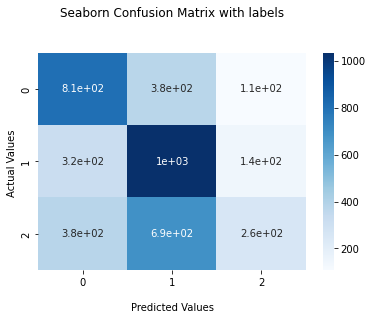

In [46]:
import seaborn as sns
r2 = sklearn.metrics.confusion_matrix(review_predictions2, integer_label)
print(r2)
ax = sns.heatmap(r2, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

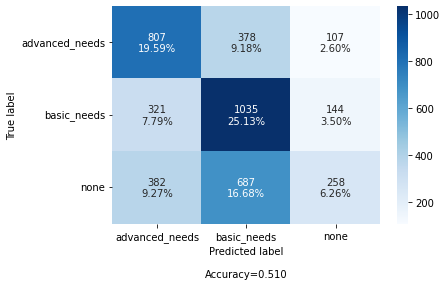

In [47]:
make_confusion_matrix(r2, group_names=uniqueClassesMaslow2, categories=uniqueClassesMaslowLabel2, cmap='Blues')

In [48]:
print(uniqueClassesMaslowLabel2)
print(uniqueClassesMaslow2)

['advanced_needs', 'basic_needs', 'none']
[0, 1, 2]


In [53]:
x_test_text = original_test_data['sentence']
x_test_text[0:5]

0    Jamies job requires her to travel a lot.She ha...
1    Andy was craving some cereal.He picked out som...
2                                 Karl locked his car.
3    I was bullied in high school.I had one bully i...
4             Kay was at work when a headache started.
Name: sentence, dtype: object

In [54]:
y_test

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [55]:
print(uniqueClassesMaslowLabel2)
print(uniqueClassesMaslow2)

['advanced_needs', 'basic_needs', 'none']
[0, 1, 2]


In [56]:
def get_mistakes(prediction_values, actual_values, test_sentences, actual_category, predicted_category,samples_shown):
    # Make sure you Map uniqueClassesMaslowLabell2 catgory with the labels mapping as index. If label is 0 then the category index in the list should be 0
    count = 0
    correct_index = uniqueClassesMaslowLabel2.index(actual_category)
    incorrect_index = uniqueClassesMaslowLabel2.index(predicted_category)
    print('Text classified as ',uniqueClassesMaslowLabel2[incorrect_index]," but actual category is ",uniqueClassesMaslowLabel2[correct_index])
    for i in range(0,len(prediction_values)):
        if prediction_values[i] == incorrect_index and actual_values[i] == correct_index and count != samples_shown:
            print(str(i),test_sentences[i])
            count = count + 1

    
get_mistakes(prediction_values = review_predictions2,
             actual_values = integer_label,
             test_sentences = x_test_text,
             actual_category = 'none', 
             predicted_category = 'basic_needs',
             samples_shown = 10)

Text classified as  basic_needs  but actual category is  none
22 Joe went to the bank to apply for a loan.
28 LLoyd was out partying one night.He was having a great time.He was also drinking a little too much.
87 Tom gave me a shirt for my birthday.I thought the shirt was very ugly and not my style.Mary's birthday was coming up next month.I put the shirt back in the box and rewrapped it.
121 Emily wanted to go on a vacation.She searched for good deals on flights everyday.Eventually she found a great deal.She booked tickets to the Bahamas.
180 Monday was making fudge with her mom.It was the holidays, the perfect time for fudge.She was stirring and stirring the hot fudge.She then slipped and threw the pan of hot fudge into the air.The fudge landed on a plate of cookies covering them all.
214 Gina's brother had a friend named Joe.Gina disliked like Joe and always left when he came around.
240 Sam needed help to move a couch in his house.
251 My aunt lives on an island in Lake Michigan.You

In [57]:
get_mistakes(prediction_values = review_predictions2,
             actual_values = integer_label,
             test_sentences = x_test_text,
             actual_category = 'advanced_needs', 
             predicted_category = 'basic_needs',
             samples_shown = 10)

Text classified as  basic_needs  but actual category is  advanced_needs
0 Jamies job requires her to travel a lot.She has no family of her own so she doesn't mind.Her friends feel sorry for her.They think at her age she should have a family.She promised herself to take her time with it and just be happy.
17 In August Billy is going overseas for the war.
26 Carrie had met a cute guy at the bar.She had given him her phone number when he asked.He promised to text her the next morning.When Carrie woke up, she tried to brace for disappointment.
33 Amy and Charles were going shopping for an engagement ring.They went to the mall and visited Kay Jewelers.They saw many rings within their price range.Amy finally saw the ring of her dreams.
38 A carnival was coming to town.Dalton loved to ride the ferris wheel.Dalton's mother warned him not to eat before getting on the ride.Dalton ate lots of carnival food that night.Dalton got sick on the ride.
44 Jerry went fishing last Sunday.He caught a lot o

In [58]:
get_mistakes(prediction_values = review_predictions2,
             actual_values = integer_label,
             test_sentences = x_test_text,
             actual_category = 'basic_needs', 
             predicted_category = 'advanced_needs',
             samples_shown = 10)

Text classified as  advanced_needs  but actual category is  basic_needs
3 I was bullied in high school.I had one bully in particular.She terrorized me almost everyday in school.
12 It was the year coming up to the millennium and Cody was scared.Everyone was saying it was the end of the world and technology.So to keep his mind off of it Cody played Pokemon Blue on his gameboy.
13 Jones exercised every night.
27 Lisa had a job interview in three days.She was nervous and unprepared.Lisa decided to study for the interview.She practiced for nine hours every day.
29 One day in 1982 my cousin called me.She works for a state agency.She told me she heard her agency was hiring.I scoffed at her, as the agency was very political.I managed to get a job.
36 Rena and Jerry went to highschool together.They immediately fell in love.
42 Cora was sad her father had passed away.She was having trouble dealing with her grief.She sat down at her piano and began to mess around.Cora's noodling turned into a fu

In [59]:
get_mistakes(prediction_values = review_predictions2,
             actual_values = integer_label,
             test_sentences = x_test_text,
             actual_category = 'none', 
             predicted_category = 'advanced_needs',
             samples_shown = 10)

Text classified as  advanced_needs  but actual category is  none
5 Kay was taking piano lessons.Her teacher was an accomplished musician.Kay was working on a piece to perform at the annual recital.She learned a lot from her teacher.
56 Juanita had always wanted to learn how to play the flute.She decided to start taking lessons.At first the flute lessons were very difficult.
59 Kate always recycles.She would crush all her cans.One day she slipped and cut her hand bad.
82 Cora wanted to get a new dress.
88 Milly's class was learning about alternative medicine.They visited an acupuncturist to learn more about it.Milly was shocked by how long the needles were.The practitioner asked for a volunteer to have a needle inserted.Milly moved to the back of the line to make sure he didn't pick her.
228 Karen rejected the supplemental coverage on her insurance.
236 Jerry was a great comedian.Everyone loved watching his routine.
321 Dennis loved comic books.He collected many different kinds.His favo

In [60]:
get_mistakes(prediction_values = review_predictions2,
             actual_values = integer_label,
             test_sentences = x_test_text,
             actual_category = 'basic_needs', 
             predicted_category = 'none',
             samples_shown = 10)

Text classified as  none  but actual category is  basic_needs
2 Karl locked his car.
4 Kay was at work when a headache started.
8 One day, Bob's dog ran out the door as Bob was leaving the house.Bob called the dog's name, but he kept running away and disappeared.
10 Cat has a science test in the morning.She decided to pull an all nighter to get ready.Since she stayed up all night she could barely stay awake.When she got to school, she fell asleep at her desk.Cat slept right through her test.
37 Shelly let her dogs out in the backyard to play.Moments later she noticed a groundhog peeking out from under the shed.She called the dogs back inside before they saw the critter.Once inside, the dogs saw the groundhog and started barking.The little groundhog ran under the fence to the neighbor's yard.
41 Carlos just got a new apartment.He needed a refrigerator.So Carlos went to the store.He found a very nice refrigerator and bought.Carlos now had a new refrigerator.
45 When Jon felt alone, he al

In [61]:
get_mistakes(prediction_values = review_predictions2,
             actual_values = integer_label,
             test_sentences = x_test_text,
             actual_category = 'advanced_needs', 
             predicted_category = 'none',
             samples_shown = 10)

Text classified as  none  but actual category is  advanced_needs
9 Lily was flying alone for the first time.
20 The horse showed up to our house.It was brown and white.No one knew where it came from.She was broken and let us ride here.
30 I was in the river fishing one day.At the bottom of the river I saw something glittery.
35 Dave had entered a raffle at work this past weekend.
40 Drawing had been an escape for Jenna since childhood in an angry home.With sidewalk chalk, she drew magical places where no one yelled.
52 Emily wanted to go on a vacation.
69 Sarah owned a small business.
83 Alex was on a camping trip.
100 Sara bought a lottery ticket.
102 The man got angry.He did something.He regretted it later.He apologized for what he did.He was never quite forgiven.
